 Análise de Logs

A série temporal é uma coleção de pontos de dados coletados em intervalos de tempo constantes. 





In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
df=pd.read_csv('logmes.csv', delimiter=',')
print('Numero de colunas:', df.shape)
df.head(5)

Numero de colunas: (43227, 5)


,minuto,requisicoes,r200,r400,tempo
0,2020-09-01 00:01:00,234,123,99,4560
1,2020-09-01 00:02:00,54,30,12,960
2,2020-09-01 00:03:00,23,10,13,460
3,2020-09-01 00:04:00,345,280,55,6800
4,2020-09-01 00:05:00,67,44,12,1230


In [2]:
df['date_time'] = df['minuto']
df['requisicoes'] = pd.to_numeric(df['requisicoes'], errors='coerce')
df = df.dropna(subset=['requisicoes'])
df['date_time']=pd.to_datetime(df['date_time']) 
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)
df=df.loc[:,['date_time','requisicoes', 'year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)
print('Número de linhas e colunas após remover linhas zeradas:', df.shape)
print('Menor data: ', df.date_time.min())
print('Maior data: ', df.date_time.max())

Número de linhas e colunas após remover linhas zeradas: (43227, 7)
Menor data:  2020-09-01 00:01:00
Maior data:  2020-09-30 23:59:20


In [3]:
stat, p = stats.normaltest(df.requisicoes)
print('Estatística=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Dados parecem ser Gaussianos (fail to reject H0)')
else:
    print('Dados nao parecem ser Gaussianos (reject H0)')


Estatística=9181.634, p=0.000
Dados nao parecem ser Gaussianos (reject H0)


Distribuição Kurtosis: -0.9291138707022233
Distribuição Skewness: 0.6129737756538419


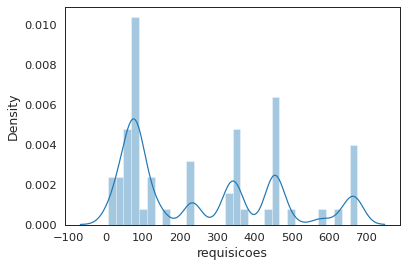

In [4]:
sns.distplot(df.requisicoes);
print( 'Distribuição Kurtosis: {}'.format(stats.kurtosis(df.requisicoes)))
print( 'Distribuição Skewness: {}'.format(stats.skew(df.requisicoes)))

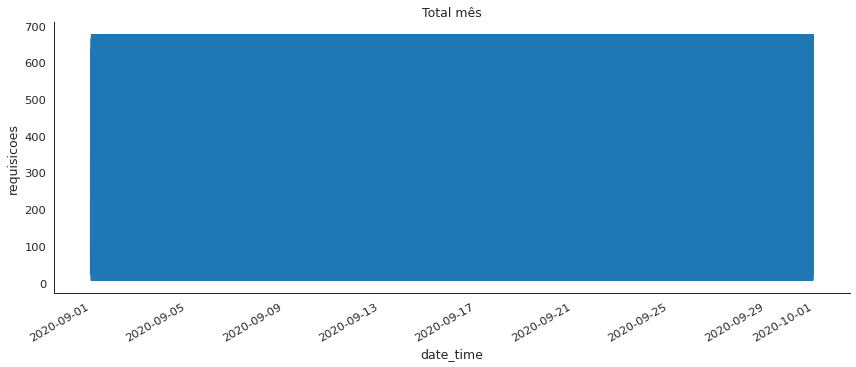

In [5]:
df1=df.loc[:,['date_time','requisicoes']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('requisicoes')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Total mês')
sns.despine(top=True)
plt.show();

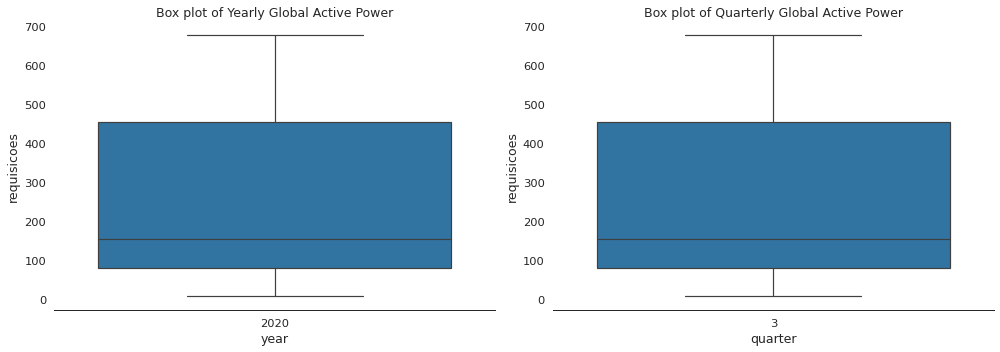

In [6]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="requisicoes", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly Global Active Power')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="requisicoes", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Global Active Power')
sns.despine(left=True)
plt.tight_layout();

,count,mean,std,min,25%,50%,75%,max
requisicoes,43227.0000,256.0636,207.3722,6.0000,78.0000,153.0000,453.0000,676.0000


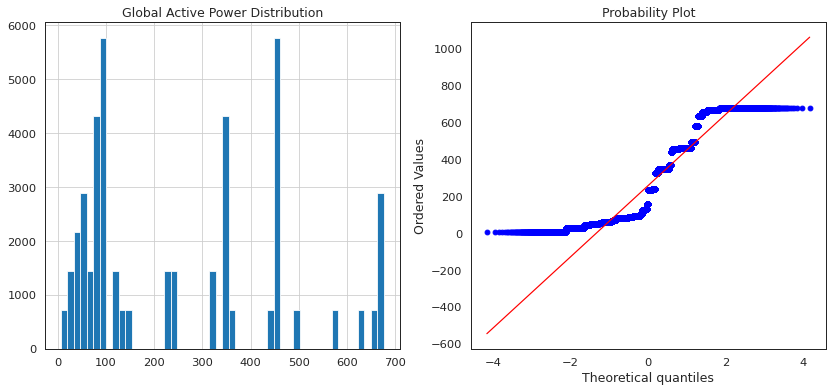

In [7]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['requisicoes'].hist(bins=50)
plt.title('Global Active Power Distribution')
plt.subplot(1,2,2)
stats.probplot(df['requisicoes'], plot=plt);
df1.describe().T

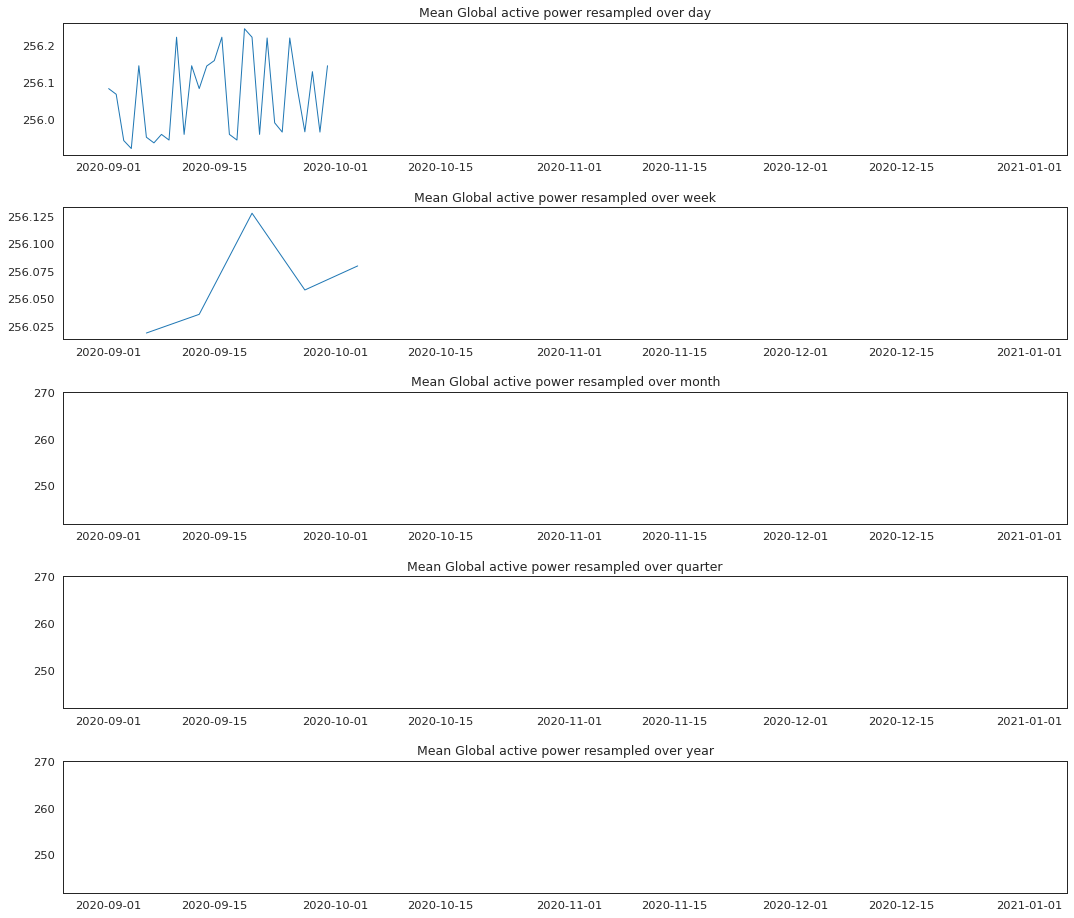

In [8]:

fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['requisicoes'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global active power resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['requisicoes'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global active power resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['requisicoes'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global active power resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['requisicoes'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global active power resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['requisicoes'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Global active power resampled over year')
ax5.tick_params(axis='both', which='major');

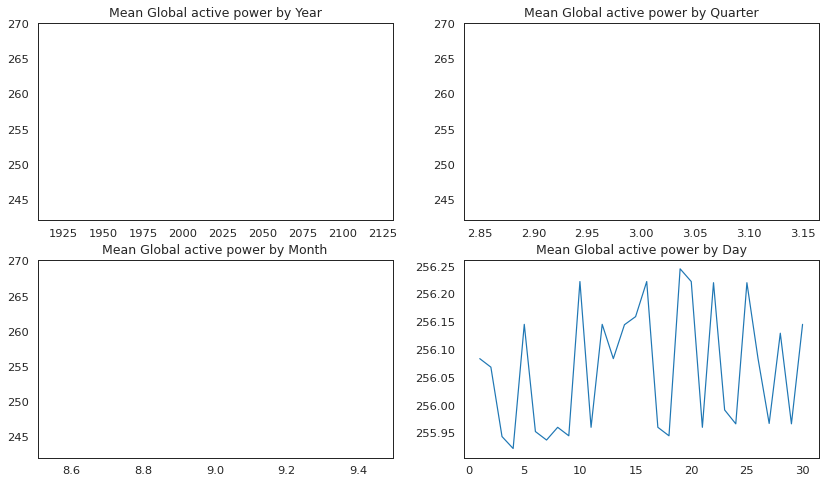

In [9]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').requisicoes.agg('mean').plot()
plt.xlabel('')
plt.title('Media por ano')

plt.subplot(2,2,2)
df.groupby('quarter').requisicoes.agg('mean').plot()
plt.xlabel('')
plt.title('Média por quartil')

plt.subplot(2,2,3)
df.groupby('month').requisicoes.agg('mean').plot()
plt.xlabel('')
plt.title('Média por mês')

plt.subplot(2,2,4)
df.groupby('day').requisicoes.agg('mean').plot()
plt.xlabel('')
plt.title('Média por dia');

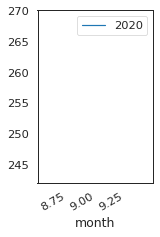

In [10]:
pd.pivot_table(df.loc[df['year'] != 2006], values = "requisicoes", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

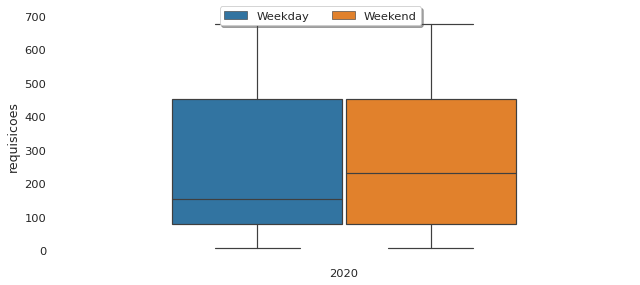

In [11]:
dic={0:'Dia da Semana',1:'Fim de semana'}
df['Day'] = df.weekday.map(dic)
a=plt.figure(figsize=(9,4)) 
plt1=sns.boxplot('year','requisicoes',hue='Day',width=0.6,fliersize=3,
                    data=df)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

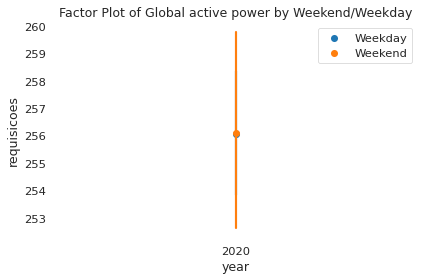

In [12]:
plt1=sns.factorplot('year','requisicoes',hue='Day',
                    data=df, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Média por dia da semana e final de semana')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

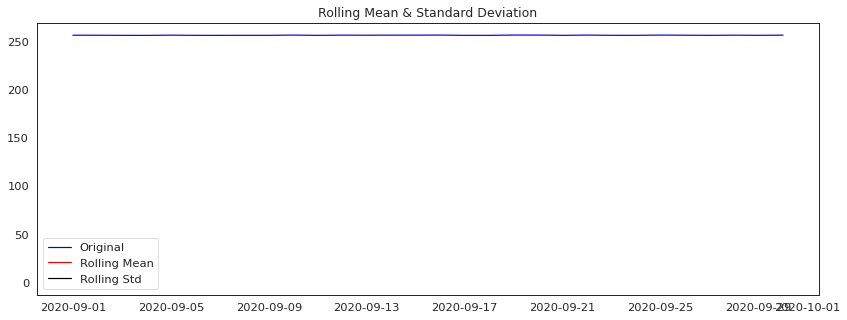

<Results of Dickey-Fuller Test>
Test Statistic                -4.2099
p-value                        0.0006
#Lags Used                     1.0000
Number of Observations Used   28.0000
Critical Value (1%)           -3.6889
Critical Value (5%)           -2.9720
Critical Value (10%)          -2.6253
dtype: float64


In [13]:
df2=df1.resample('D', closed='right', label='left').mean()

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(df2)

In [14]:
dataset = df.requisicoes.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [15]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Epoch 1/20
494/494 [==============================] - 2s 3ms/step - loss: 0.0354 - val_loss: 0.0015
Epoch 2/20
494/494 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 2.3345e-04
Epoch 3/20
494/494 [==============================] - 1s 3ms/step - loss: 0.0023 - val_loss: 1.4108e-04
Epoch 4/20
494/494 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 1.4715e-04
Epoch 5/20
494/494 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 1.4131e-04
Epoch 6/20
494/494 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 1.1473e-04
Epoch 7/20
494/494 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 3.9182e-05
Epoch 8/20
494/494 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 1.7401e-04
Epoch 9/20
494/494 [==============================] - 1s 3ms/step - loss: 9.7741e-04 - val_loss: 5.8569e-05
Epoch 10/20
494/494 [==============================] - 1s 3ms/st

In [16]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Erro absoluto de treinamento:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Raiz para erro de treinamento:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Erro absoluto de teste:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Raiz para erro de teste:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 3.143182529385096
Train Root Mean Squared Error: 4.111373485392967
Test Mean Absolute Error: 3.1422047511888493
Test Root Mean Squared Error: 4.110523747858487


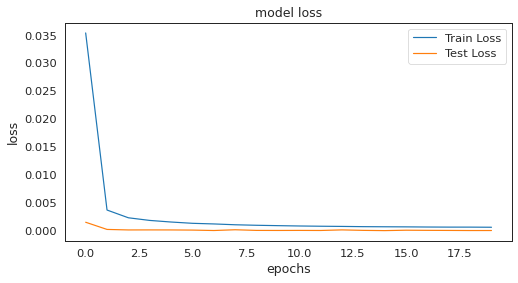

In [17]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

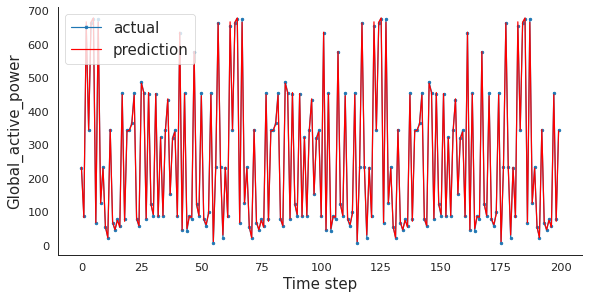

In [18]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();